In [1]:
# TODO
# Collect at least 1000 gray image
# resize them 32X32 (1024)
# construct data matrix and covariance matrix using face image
# SVD ( PCA ) to the covariance matrix
# eigenvectors for largest singular values
# FINAL : Test for the recognition

In [2]:
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt

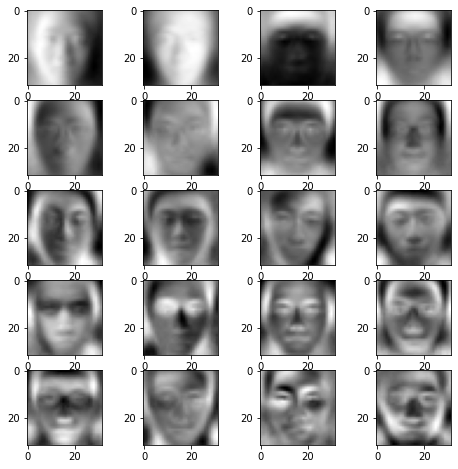

In [3]:
file_M_path = "./res/faces/M/"
file_F_path = "./res/faces/F/"
file_M_list = os.listdir("./res/faces/M/")
file_F_list = os.listdir("./res/faces/F/")

man_pics = []
for file_M in file_M_list:
    man_pics.append(np.array(
        cv2.resize(cv2.imread(file_M_path + file_M, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())

sum_of_pics = sum(man_pics)

mean_of_pics = sum_of_pics / len(man_pics)

translation = man_pics - mean_of_pics

U, s, V = np.linalg.svd(translation, full_matrices = True)

S = np.zeros(translation.shape)
for i in range(len(s)):
     S[i][i] = s[i]

appA = np.dot(U, np.dot(S, V))

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = V[i].reshape(32,32)
#     img = l[np.random.randint(1024)].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [4]:
"""
face_cascade = cv2.CascadeClassifier('haarcascade_frontface.xml')
original_path = "./res/original/"
test_file_list = os.listdir(original_path)
for folder in test_file_list[3]:
    files = os.listdir(original_path + folder)
    for i, file_path in enumerate(files):
        cur_path = original_path + folder + "/"
        frame = cv2.imread(cur_path + file_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        if len(faces):
            directory = os.path.dirname(cur_path + "ex/")
            if not os.path.exists(directory):
                print("Make")
                os.makedirs(directory)
            print("face detected")
            x,y,w,h = faces[0]
            print(cur_path + "ex/" + "result-" + str(i) + ".jpg")
            cv2.imwrite(cur_path + "ex/" + "result-" + str(i) + ".jpg", frame[y:y+h, x:x+w])
"""

'\nface_cascade = cv2.CascadeClassifier(\'haarcascade_frontface.xml\')\noriginal_path = "./res/original/"\ntest_file_list = os.listdir(original_path)\nfor folder in test_file_list[3]:\n    files = os.listdir(original_path + folder)\n    for i, file_path in enumerate(files):\n        cur_path = original_path + folder + "/"\n        frame = cv2.imread(cur_path + file_path)\n        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n        faces = face_cascade.detectMultiScale(gray, 1.3, 5)\n        if len(faces):\n            directory = os.path.dirname(cur_path + "ex/")\n            if not os.path.exists(directory):\n                print("Make")\n                os.makedirs(directory)\n            print("face detected")\n            x,y,w,h = faces[0]\n            print(cur_path + "ex/" + "result-" + str(i) + ".jpg")\n            cv2.imwrite(cur_path + "ex/" + "result-" + str(i) + ".jpg", frame[y:y+h, x:x+w])\n'

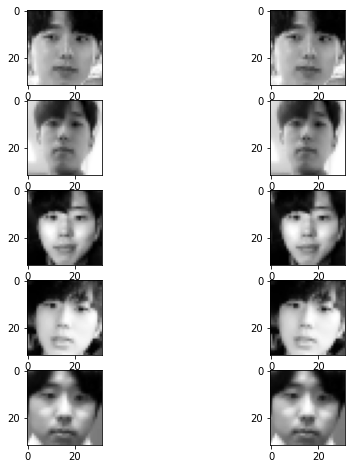

In [5]:
test_path = "./res/original/9/ex/"
test_file_list = os.listdir(test_path)
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread(test_path + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    test_pics.append(pic)
    weights.append((pic - mean_of_pics) @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:1024]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()

In [6]:
# Measuring similarity
test_faces_path = "./res/original/"
test_folders = os.listdir(test_faces_path)
face_eigen_values = []

def find_sim(ev, faces_eigen):
    euclidean_distances = []
    cosine_similarities = []
    for idx, pivot in enumerate(faces_eigen):
        euclidean_distances.append(np.linalg.norm(ev - ev @ pivot * pivot))
        cosine_similarities.append(ev @ pivot / np.linalg.norm(ev))
    return euclidean_distances , cosine_similarities

for test_folder in test_folders:
    face_files = os.listdir(test_faces_path + test_folder + "/ex/")
    cropped_path = test_faces_path + test_folder + "/ex/"
    eigens = []
    for face_file in face_files:
        face_vec = np.array(cv2.resize(cv2.imread(cropped_path + face_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
        eigens.append(face_vec @ V.T)
    face_eigen_values.append(eigens)
    
mean_eigen_values = []
for fev in face_eigen_values:
    mean_eigen = sum(fev) / len(fev)
    mean_eigen_values.append(mean_eigen / np.linalg.norm(mean_eigen))

for i, face_eigen_list in enumerate(face_eigen_values):
    pivot_vec = mean_eigen_values[i] / np.linalg.norm(mean_eigen_values[i])
    print("TEST {} face".format(str(i)))
    for fev in face_eigen_list:
        e, c = find_sim(fev, mean_eigen_values)
        se = sorted(e)
        sc = sorted(c, reverse=True)
        
        print("euclidean 1st {}, 2nd {}".format(np.where(e == se[0])[0][0], np.where(e == se[1])[0][0], se[1] * 100))
        print("cosine    1st {}, 2nd {}".format(np.where(c == sc[0])[0][0], np.where(c == sc[1])[0][0], sc[1] * 100))
        
    print("")

TEST 0 face
euclidean 1st 0, 2nd 3
cosine    1st 0, 2nd 3
euclidean 1st 0, 2nd 3
cosine    1st 0, 2nd 3
euclidean 1st 4, 2nd 9
cosine    1st 4, 2nd 9
euclidean 1st 0, 2nd 2
cosine    1st 0, 2nd 2
euclidean 1st 0, 2nd 9
cosine    1st 0, 2nd 9

TEST 1 face
euclidean 1st 8, 2nd 7
cosine    1st 8, 2nd 7
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5

TEST 2 face
euclidean 1st 2, 2nd 0
cosine    1st 2, 2nd 0
euclidean 1st 2, 2nd 7
cosine    1st 2, 2nd 7
euclidean 1st 2, 2nd 0
cosine    1st 2, 2nd 0
euclidean 1st 2, 2nd 0
cosine    1st 2, 2nd 0
euclidean 1st 3, 2nd 7
cosine    1st 3, 2nd 7

TEST 3 face
euclidean 1st 3, 2nd 7
cosine    1st 3, 2nd 7
euclidean 1st 3, 2nd 8
cosine    1st 3, 2nd 8
euclidean 1st 3, 2nd 8
cosine    1st 3, 2nd 8
euclidean 1st 3, 2nd 7
cosine    1st 3, 2nd 7
euclidean 1st 3, 2nd 8
cosine    1st 3, 2nd 8

TEST 4 face
euclidean 1st 4,

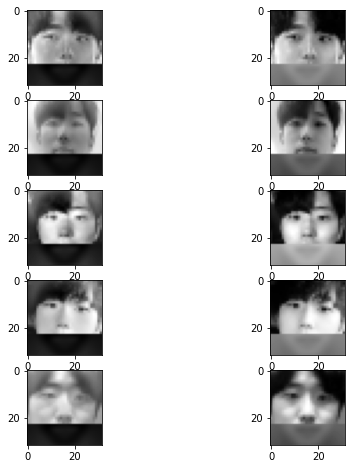

In [17]:
test_path = "./res/original/9/ex/"
test_file_list = os.listdir(test_path)
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread(test_path + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    pic = np.concatenate((pic[:512 + 224], np.array([1 for i in range(512 - 224)])))
    test_pics.append(pic)
    pic -= mean_of_pics
    pic = np.concatenate((pic[:512 + 224], np.array([1 for i in range(512 - 224)])))
    weights.append(pic @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()

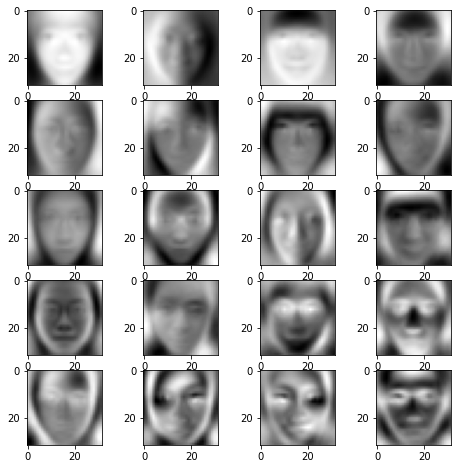

In [8]:
file_M_path = "./res/faces/M/"
file_F_path = "./res/faces/F/"
file_M_list = os.listdir("./res/faces/M/")
file_F_list = os.listdir("./res/faces/F/")

people_pics = []
for file_M in file_M_list:
    people_pics.append(np.array(
        cv2.resize(cv2.imread(file_M_path + file_M, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())

for file_F in file_F_list:
    people_pics.append(np.array(
        cv2.resize(cv2.imread(file_F_path + file_F, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())
random.shuffle(people_pics)
sum_of_pics = sum(people_pics)

mean_of_pics = sum_of_pics / len(people_pics)

translation = people_pics - mean_of_pics

U, s, V = np.linalg.svd(translation, full_matrices = True)

S = np.zeros(translation.shape)
for i in range(len(s)):
     S[i][i] = s[i]

appA = np.dot(U, np.dot(S, V))

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = V[i].reshape(32,32)
#     img = l[np.random.randint(1024)].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [10]:
# Measuring similarity
test_faces_path = "./res/original/"
test_folders = os.listdir(test_faces_path)
face_eigen_values = []

def find_sim(ev, faces_eigen):
    euclidean_distances = []
    cosine_similarities = []
    for idx, pivot in enumerate(faces_eigen):
        euclidean_distances.append(np.linalg.norm(ev - ev @ pivot * pivot))
        cosine_similarities.append(ev @ pivot / np.linalg.norm(ev))
    return euclidean_distances , cosine_similarities

for test_folder in test_folders:
    face_files = os.listdir(test_faces_path + test_folder + "/ex/")
    cropped_path = test_faces_path + test_folder + "/ex/"
    eigens = []
    for face_file in face_files:
        face_vec = np.array(cv2.resize(cv2.imread(cropped_path + face_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
        eigens.append(face_vec @ V.T)
    face_eigen_values.append(eigens)
    
mean_eigen_values = []
for fev in face_eigen_values:
    mean_eigen = sum(fev) / len(fev)
    mean_eigen_values.append(mean_eigen / np.linalg.norm(mean_eigen))

for i, face_eigen_list in enumerate(face_eigen_values):
    pivot_vec = mean_eigen_values[i] / np.linalg.norm(mean_eigen_values[i])
    print("TEST {} face".format(str(i)))
    for fev in face_eigen_list:
        e, c = find_sim(fev, mean_eigen_values)
        se = sorted(e)
        sc = sorted(c, reverse=True)
        print("euclidean 1st {}, 2nd {}".format(np.where(e == se[0])[0][0], np.where(e == se[1])[0][0], se[1] * 100))
        print("cosine    1st {}, 2nd {}".format(np.where(c == sc[0])[0][0], np.where(c == sc[1])[0][0], sc[1] * 100))
    print("")

TEST 0 face
euclidean 1st 0, 2nd 3
cosine    1st 0, 2nd 3
euclidean 1st 0, 2nd 3
cosine    1st 0, 2nd 3
euclidean 1st 4, 2nd 9
cosine    1st 4, 2nd 9
euclidean 1st 0, 2nd 2
cosine    1st 0, 2nd 2
euclidean 1st 0, 2nd 9
cosine    1st 0, 2nd 9

TEST 1 face
euclidean 1st 8, 2nd 7
cosine    1st 8, 2nd 7
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5
euclidean 1st 1, 2nd 5
cosine    1st 1, 2nd 5

TEST 2 face
euclidean 1st 2, 2nd 0
cosine    1st 2, 2nd 0
euclidean 1st 2, 2nd 7
cosine    1st 2, 2nd 7
euclidean 1st 2, 2nd 0
cosine    1st 2, 2nd 0
euclidean 1st 2, 2nd 0
cosine    1st 2, 2nd 0
euclidean 1st 3, 2nd 7
cosine    1st 3, 2nd 7

TEST 3 face
euclidean 1st 3, 2nd 7
cosine    1st 3, 2nd 7
euclidean 1st 3, 2nd 8
cosine    1st 3, 2nd 8
euclidean 1st 3, 2nd 8
cosine    1st 3, 2nd 8
euclidean 1st 3, 2nd 7
cosine    1st 3, 2nd 7
euclidean 1st 3, 2nd 8
cosine    1st 3, 2nd 8

TEST 4 face
euclidean 1st 4,

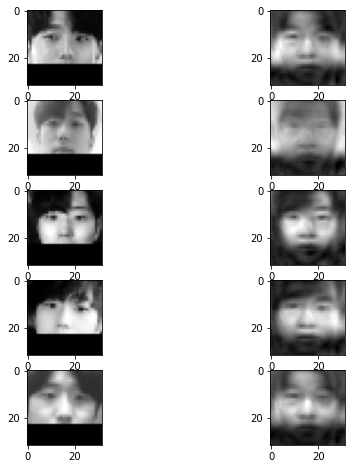

In [8]:
test_path = "./res/original/9/ex/"
test_file_list = os.listdir(test_path)
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread(test_path + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    pic = np.concatenate((pic[:512 + 224], np.array([1 for i in range(512 - 224)])))
    test_pics.append(pic)
    w = (pic - mean_of_pics) @ V.T
#     w = np.concatenate((w[:512 + 224], + np.array([1 for i in range(512 - 224)])))
    weights.append(w)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:64]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img , cmap='gray')
plt.show()

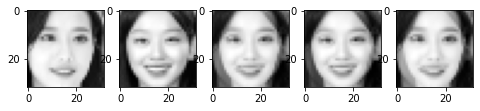

In [36]:
test_0_path = "./res/original/7/ex/result-3.jpg"
test_1_path = "./res/original/8/ex/result-2.jpg"

pic1 = np.array(cv2.resize(cv2.imread(test_0_path, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
w1 = (pic1 - mean_of_pics) @ V.T

pic2 = np.array(cv2.resize(cv2.imread(test_1_path, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
w2 = (pic2 - mean_of_pics) @ V.T

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(pic1.reshape(32,32), cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(pic2.reshape(32,32) , cmap='gray')

w_merge1 = np.diag((w1 + w2) / 2)
restored_img = w_merge1 @ V
restored_img = (sum(restored_img) + mean_of_pics).reshape(32, 32)
fig.add_subplot(rows, columns, 3)
plt.imshow(restored_img , cmap='gray')

w_merge2 = np.diag(w1 * 0.3 + w2 * 0.7)
restored_img = w_merge2 @ V
restored_img = (sum(restored_img) + mean_of_pics).reshape(32, 32)
fig.add_subplot(rows, columns, 4)
plt.imshow(restored_img , cmap='gray')

w_merge3 = np.diag(w1 * 0.7 + w2 * 0.3)
restored_img = w_merge3 @ V
restored_img = (sum(restored_img) + mean_of_pics).reshape(32, 32)
fig.add_subplot(rows, columns, 5)
plt.imshow(restored_img , cmap='gray')

plt.show()